# Sequence to Sequence Modelling

**Note**: Please use Python 3 and Keras version of 2.0.4. 



![title](seq2seq.png)

In this project, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs

The first part of the project is to prepare data. We are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. We will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get started and we recommend experimenting, to improve the scores after you are done with your first implementation)

In [1]:
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
import operator
from keras.callbacks import TensorBoard
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from numpy import argmax
from rouge import Rouge
from attention_decoder import AttentionDecoder
from keras.layers import Embedding,Dense, Dropout, Reshape, RepeatVector,Merge, BatchNormalization, TimeDistributed, Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D

Using TensorFlow backend.


In [97]:
MAX_LEN = 24
VOCAB_SIZE = 20000

Following function takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [111]:
#map words in text data to their corresponding index from word2idx, use index of unk if word is not represent in the vocab.
def text_sequence (text, word2idx):
    idx_unk = word2idx.get('<unk>')
    data=[]   
    for i in range(len(text)):
        #split text to words, keep all punctuations
        sequence=text_to_word_sequence(text[i],filters='',lower=True,split=" ")
        new_sequence=[word2idx[n] if n in word2idx else idx_unk for n in sequence] 
        data.append(new_sequence)
    return data



def load_data(article, summary, max_len, vocab_size):
    tokenizer_X = Tokenizer(num_words=None,filters='',lower=True,split=" ")
    tokenizer_X.fit_on_texts(article)
    #number of words with counts in article data
    words_X=tokenizer_X.word_counts
    #sort frequent words by reverse order 
    top_words_X=sorted(words_X.items(), key=operator.itemgetter(1), reverse=True)
    #top vocab_size words
    idx2word_X=[x[0] for x in top_words_X][:vocab_size]
    #add 0 to the vocab list
    idx2word_X.insert(0,'0')
    #dictionary mapping words to their index according to the rank (most frequent)
    word_idx_X=tokenizer_X.word_index
    #top vocab_size words and their corresponding index
    word2idx_X={key:value for key, value in word_idx_X.items() if key in idx2word_X}
    #Add index 0 to symbol '0'
    word2idx_X['0']=0
    #check word2idx_X items
    #print (sorted(word2idx_X.items(), key=operator.itemgetter(1), reverse=False))

    #repeat the process for summary data
    tokenizer_Y = Tokenizer(num_words=None,filters='',lower=True,split=" ")
    tokenizer_Y.fit_on_texts(summary)
    #number of words with counts in summary data
    words_Y=tokenizer_Y.word_counts
    top_words_Y=sorted(words_Y.items(), key=operator.itemgetter(1), reverse=True)
    idx2word_Y=[y[0] for y in top_words_Y][:vocab_size]
    idx2word_Y.insert(0,'0')
    word_idx_Y=tokenizer_Y.word_index
    word2idx_Y={key:value for key, value in word_idx_Y.items() if key in idx2word_Y}
    word2idx_Y['0']=0

    #transform text data to sequence and paddig 
    sequence_X=text_sequence(article, word2idx_X)
    article_sequence = pad_sequences(sequence_X, maxlen=max_len, padding='post', truncating='post')
    sequence_Y=text_sequence(summary, word2idx_Y)
    summary_sequence = pad_sequences(sequence_Y, maxlen=max_len, padding='post', truncating='post')

    
    
    return article_sequence, len(idx2word_X), idx2word_X, word2idx_X, summary_sequence, len(idx2word_Y), idx2word_Y, word2idx_Y


In [112]:

f_tr_X=open('data/train_article.txt', 'r')
train_article=f_tr_X.read().splitlines()
f_tr_Y=open('data/train_title.txt', 'r')
train_title=f_tr_Y.read().splitlines()

X_train, vocab_size_X, idx2word_X, word2idx_X, Y_train, vocab_size_Y, idx2word_Y,word2idx_Y = load_data (train_article,train_title,MAX_LEN, VOCAB_SIZE)



Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

# Unidirectional LSTM Encoder Decoder 

Define the parameters for LSTM encoder decoder model. 

In [100]:
BATCH_SIZE = 320
NUM_LAYERS = 1
HIDDEN_DIM = 600
EPOCHS = 100

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [101]:
def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    
    # create and return the model for unidirectional LSTM encoder decoder
    model = Sequential()
    #encoder
    model.add(Embedding(input_dim=X_vocab_len, output_dim=hidden_size, input_length=MAX_LEN,mask_zero=True,trainable=False))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(MAX_LEN))
    
    #decoder
    for _ in range (num_layers):
        model.add (LSTM(hidden_size, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])    
    
    model.summary()
    return model

    

# Train the Model

Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [102]:
model=create_UniLSTM(vocab_size_X,MAX_LEN,vocab_size_Y,MAX_LEN,HIDDEN_DIM,NUM_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 600)           12000600  
_________________________________________________________________
lstm_3 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 600)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 600)           2882400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 20001)         12020601  
_________________________________________________________________
activation_1 (Activation)    (None, 24, 20001)         0         
Total params: 29,786,001
Trainable params: 17,785,401
Non-trainable params: 12,000,600
_______________________________________________________

In [ ]:
batch_size=1000
for k in range(EPOCHS):
    for i in range(0, len(X_train), batch_size):
        if i + batch_size >= len(X_train):
            length = len(X_train)
        else:
            length = i + batch_size
        y=Y_train[i:length]
        one_hot_Y = (np.arange(Y_train.max()+1) == y[...,None]).astype(int)

        
        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X_train)))
        model.fit(X_train[i:length], one_hot_Y, batch_size=BATCH_SIZE, validation_split=0.2, 
                  epochs=1,verbose=1,shuffle = True)

        
    model.save_weights(path_W + '/weight_epo_{}.h5'.format(k))

# Evaluation using Rouge score 

Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [113]:
#Literature has reported a ROUGE 2 score ranging from 4.6 - 8.9, use recall
f_te_X=open('data/test_article.txt', 'r')
test_article=f_te_X.read().split('\n') #test_article
f_te_Y=open('data/test_title.txt', 'r')
test_title=f_te_Y.read().split('\n')  #test_title
#converting words outside train vocabulary in the test article data to UNK 
te_X_seq=text_sequence(test_article, word2idx_X) 
#pad sequence of test_article data:input for the model
X_test = pad_sequences(te_X_seq, maxlen=MAX_LEN, padding='post', truncating='post')#transformed test_article

#not converting test_title, use it compare with predicted output
Y_test_words=[]   
for i in range(len(test_title)):
    #split text to words, keep all punctuations
    sequence=text_to_word_sequence(test_title[i],filters='',lower=True,split=" ")
    Y_test_words.append(sequence)

In [114]:
#decode 3d one_hot array to 2d array
def onehot_decode (threeDarray):
    return np.array (list(np.argmax(row,axis=1) for row in threeDarray))

#def onehot_decode(threeDarray):
    #return [argmax(vector) for vector in threeDarray]


#map index to words corresponding to the values in word2idx dictionary

def idx_to_word(word2idx, idx_list):
    idx2word_dict = {y:x for x,y in word2idx.items()}
    words_list=list(map(idx2word_dict.get, idx_list))
    return words_list

In [ ]:
model.load_weights('./UniLSTM/Weight/final_weight.h5')

y_pred = model.predict(X_test, verbose=0)
y_pred_decode = onehot_decode(y_pred)

pred_words=[]
for i in range(len(test_article)): 
    pred_word_list=idx_to_word(word2idx_Y,y_pred_decode[i])
    #remove 0s from word list
    pred_word_rm0=list(filter(lambda a: a != '0', pred_word_list))    
    pred_words.append(pred_word_rm0)
    

    


In [16]:
pred_list=[" ".join(k) for k in pred_words]
rouge = Rouge()
scores = rouge.get_scores(test_title, pred_list, avg=True)

print ('Rouge 1 r:', scores.get('rouge-1')['r'])
print ('Rouge 1 f:', scores.get('rouge-1')['f'])

print ('Rouge 2 r:', scores.get('rouge-2')['r'])
print ('Rouge 2 f:', scores.get('rouge-2')['f'])


Rouge 1 r: 0.120405708418
Rouge 1 f: 0.0910325046791
Rouge 2 r: 0.0164884041509
Rouge 2 f: 0.0152643693869


In [17]:
for i in range (1000):
    print ('gold summary {}:'.format (i+1), test_title[i])
    print ('predicted summary {}:'.format (i+1), pred_list[i])

gold summary 1: london share prices up at midday
predicted summary 1: london stock penguins index at most at at
gold summary 2: london share prices down at midday
predicted summary 2: london s penguins index at most at at at
gold summary 3: kewell ready for jeers when liverpool hosts leeds
predicted summary 3: straka signs surprises crushes to to to
gold summary 4: most rwc tries conceded list
predicted summary 4: work wins chick to in rather world world world
gold summary 5: u.s. open referee masters art of juggling
predicted summary 5: <unk> <unk> standby microwave
gold summary 6: san jose defenseman gary suter to retire
predicted summary 6: <unk> <unk> <unk> weinke asylum <unk> <unk>
gold summary 7: stocks finish down in mexico chile ; rise sharply in argentina
predicted summary 7: china rises rises in tale ponder
gold summary 8: the green book _ ##,### songs #,### categories _ popular with industry pros music geeks
predicted summary 8: asiad 's to to janez to helmets the
gold summa

gold summary 966: every day is fantastic for prolific ray bradbury
predicted summary 966: roger bread to slutskaya to in in
gold summary 967: reutimann gets closer to big ride
predicted summary 967: <unk> <unk> world to to to giant
gold summary 968: musselman 's <unk> says artest is coach 's dream
predicted summary 968: work <unk> to <unk> <unk> <unk> in
gold summary 969: squirrel cuts power at college
predicted summary 969: regional beats qatar in in in
gold summary 970: more morbid kennedy fascination
predicted summary 970: <unk> veggies <unk> in at
gold summary 971: woods aims to improve in #nd season
predicted summary 971: russian enchants to to to <unk>
gold summary 972: golden state warriors sign carl thomas to ##-day contract
predicted summary 972: uconn to abu in
gold summary 973: eugene robinson talks it up at the super bowl
predicted summary 973: <unk> <unk> to to sanofi to
gold summary 974: carlson says oilers must take small steps to improve
predicted summary 974: nuke surf

# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [18]:
def generator(input_data, output_data, batch_size):
    while True:
        for i in range(0,len(input_data),batch_size):
            if i + batch_size >= len(input_data):
                length=len(input_data)
            else:
                length=i+batch_size
            
            y=output_data[i:length]
            one_hot_y = (np.arange(output_data.max()+1) == y[...,None]).astype(int)
                
            yield (input_data[i:length], one_hot_y)

tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
model.fit_generator(generator(X_train,Y_train,100),steps_per_epoch=200, epochs=10,verbose=1,callbacks=[tensorboard])

Epoch 1/10
200/200 [==============================] - 121s - loss: 2.7270 - acc: 0.7002   
Epoch 2/10
200/200 [==============================] - 120s - loss: 2.4281 - acc: 0.7119   
Epoch 3/10
200/200 [==============================] - 121s - loss: 2.4431 - acc: 0.7054   
Epoch 4/10
200/200 [==============================] - 120s - loss: 2.3624 - acc: 0.7086   
Epoch 5/10
200/200 [==============================] - 120s - loss: 2.2967 - acc: 0.7139   
Epoch 6/10
200/200 [==============================] - 121s - loss: 2.3325 - acc: 0.7074   
Epoch 7/10
200/200 [==============================] - 121s - loss: 2.2294 - acc: 0.7167   
Epoch 8/10
200/200 [==============================] - 121s - loss: 2.2700 - acc: 0.7093   
Epoch 9/10
200/200 [==============================] - 120s - loss: 2.2311 - acc: 0.7115   
Epoch 10/10
200/200 [==============================] - 121s - loss: 2.1643 - acc: 0.7165   


<img src="acc.PNG">

<img src="loss.PNG">

# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for LSTM encoder decoder model with attention

In [110]:
MAX_LEN = 24
VOCAB_SIZE = 10097  #words appear more than 5 times in train_article
BATCH_SIZE = 320
NUM_LAYERS = 1
HIDDEN_DIM = 128
EPOCHS = 100

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [84]:
from attention_decoder import AttentionDecoder

def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):

    
    model = Sequential()
    model.add(Embedding(input_dim=X_vocab_len, output_dim=hidden_size, input_length=MAX_LEN,mask_zero=True,trainable=True))
    for _ in range (num_layers):
        model.add(LSTM(hidden_size,return_sequences=True, dropout=0.2,recurrent_dropout=0.2))    
    model.add(AttentionDecoder(hidden_size, X_vocab_len))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Train the Model

Train the model, as you did before, for the model without attention

In [ ]:

path_W="./UniLSTM_Attn/Weight"

batch_size=2000
#path_M='./UniLSTM_Attn/Model'
for k in range(1,EPOCHS+1):
    for i in range(0, len(X_train), batch_size):
        if i + batch_size >= len(X_train):
            length = len(X_train)
        else:
            length = i + batch_size
        
        y=Y_train[i:length]
        one_hot_Y = (np.arange(Y_train.max()+1) == y[...,None]).astype(int)
        
        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X_train)))
        model_att.fit(X_train[i:length], one_hot_Y, batch_size=BATCH_SIZE, validation_split=0.2, 
                  epochs=1,verbose=1,shuffle = True)

        
    model_att.save_weights('./UniLSTM_Attn/Weight/weight_epo_{}.h5'.format(k))
model_att.save_weights('./UniLSTM_Attn/Weight/final_attn_weight.h5')


In [115]:
print (vocab_size_X,MAX_LEN,vocab_size_Y,MAX_LEN,HIDDEN_DIM,NUM_LAYERS)

10098 24 10098 24 128 1


In [8]:
Pred_model=create_UniLSTMwithAttention(vocab_size_X,MAX_LEN,vocab_size_Y,MAX_LEN,HIDDEN_DIM,NUM_LAYERS,return_probabilities = False)

Prob_model=create_UniLSTMwithAttention(vocab_size_X,MAX_LEN,vocab_size_Y,MAX_LEN,HIDDEN_DIM,NUM_LAYERS,return_probabilities = True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 128)           1292544   
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 24, 10098)         108590518 
Total params: 110,014,646
Trainable params: 110,014,646
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 128)           1292544   
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 128)           131584    
______________________________________________________________

# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [66]:
Pred_model.load_weights('./UniLSTM_Attn/Weight/weight_epo_53.h5')

In [86]:
f_te_X=open('data/test_article.txt', 'r')
test_article=f_te_X.read().split('\n') #test_article
f_te_Y=open('data/test_title.txt', 'r')
test_title=f_te_Y.read().split('\n')  #test_title
#converting words outside train vocabulary in the test article data to UNK 
te_X_seq=text_sequence(test_article, word2idx_X) 
#pad sequence of test_article data:input for the model
X_test = pad_sequences(te_X_seq, maxlen=MAX_LEN, padding='post', truncating='post')#transformed test_article

#not converting test_title, use it compare with predicted output
Y_test_words=[]   
for i in range(len(test_title)):
    #split text to words, keep all punctuations
    sequence=text_to_word_sequence(test_title[i],filters='',lower=True,split=" ")
    Y_test_words.append(sequence)

In [87]:
def onehot_decode (threeDarray):
    return np.array (list(np.argmax(row,axis=1) for row in threeDarray))

#def onehot_decode(threeDarray):
    #return [argmax(vector) for vector in threeDarray]


#map index to words corresponding to the values in word2idx dictionary

def idx_to_word(word2idx, idx_list):
    idx2word_dict = {y:x for x,y in word2idx.items()}
    words_list=list(map(idx2word_dict.get, idx_list))
    return words_list

In [94]:
Pred_model.load_weights('./UniLSTM_Attn/Weight/weight_epo_53.h5')

y_pred_att = Pred_model.predict(X_test, verbose=0)
y_pred_att_decode = onehot_decode(y_pred_att)

pred_words_att=[]
for i in range(len(test_article)): 
    pred_word_att_list=idx_to_word(word2idx_Y, y_pred_att_decode[i])
    #remove 0s from word list
    pred_word_att_rm0=list(filter(lambda a: a != '0', pred_word_att_list))    
    pred_words_att.append(pred_word_att_rm0)



In [96]:
from rouge import Rouge
pred_list_att=[" ".join(k) for k in pred_words_att]
rouge_att = Rouge()
scores_att = rouge_att.get_scores(test_title, pred_list_att, avg=True)
print ('Rouge 1 r:', scores_att.get('rouge-1')['r'])
print ('Rouge 1 f:', scores_att.get('rouge-1')['f'])
print ('Rouge 1 p:', scores_att.get('rouge-1')['p'])

print ('\nRouge 2 r:', scores_att.get('rouge-2')['r'])
print ('Rouge 2 f:', scores_att.get('rouge-2')['f'])
print ('Rouge 2 p:', scores_att.get('rouge-2')['p'])

print ('\nRouge L r:', scores_att.get('rouge-l')['r'])
print ('Rouge L f:', scores_att.get('rouge-l')['f'])
print ('Rouge L p:', scores_att.get('rouge-l')['p'])

Rouge 1 r: 0.17698441039
Rouge 1 f: 0.10162809106
Rouge 1 p: 0.080318126537

Rouge 2 r: 0.02703219268
Rouge 2 f: 0.0227460844951
Rouge 2 p: 0.0215580753897

Rouge L r: 0.0971633450744
Rouge L f: 0.0807535074383
Rouge L p: 0.0800946790197


In [31]:
for i in range (1000):
    print ('Article Sentense {}:'.format (i+1), test_article[i])
    print ('Non_Attn Model {}:'.format (i+1), pred_list[i])
    print ('Attn Model {}:'.format (i+1), pred_list_att[i])

Article Sentense 1: share prices on the london stock exchange were higher at midday tuesday .
Attn predicted sentense 1: london s fa index up
Article Sentense 2: share prices on the london stock exchange were lower at midday thursday .
Attn predicted sentense 2: london s fa index lower
Article Sentense 3: liverpool midfielder harry kewell will probably hear some boos saturday .
Attn predicted sentense 3: <unk> hello <unk> <unk>
Article Sentense 4: namibia goes home from the rugby world cup with the most tries conceded .
Attn predicted sentense 4: world 's to to to world
Article Sentense 5: two days of rain at the u.s. open have complicated brian earley 's life .
Attn predicted sentense 5: opens u.s. u.s. u.s. u.s. u.s.
Article Sentense 6: gary suter , a four-time nhl all-star defenseman , is to retire tuesday .
Attn predicted sentense 6: british of <unk> <unk> in <unk>
Article Sentense 7: mexican stocks closed lower thursday , dragged down again by u.s. bears .
Attn predicted sentense 

Attn predicted sentense 622: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Article Sentense 623: it 's no secret that oscar campaigns are a lot like political campaigns .
Attn predicted sentense 623: <unk> <unk> <unk> <unk> <unk>
Article Sentense 624: let us all now say a small prayer of thanks for canada and its currency .
Attn predicted sentense 624: jeremy 's 's 's in in suddenly
Article Sentense 625: cablevision shares fell ## cents , or #.# percent , to close at $ ##.## .
Attn predicted sentense 625: <unk> 's down down percent in
Article Sentense 626: -- average national cost per year of <unk> nursing-home care : $ ##,### .
Attn predicted sentense 626: <unk> <unk> <unk> <unk> <unk>
Article Sentense 627: there will be cherry trees on center field plaza and cherry pie as well .
Attn predicted sentense 627: <unk> <unk> <unk> <unk> <unk> <unk>
Article Sentense 628: guidebook czar rick steves never met a european country he did n't like .
Attn predicted sentense 628: <unk> <unk> <unk

# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

In [53]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [48]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(self.pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

You can initialize Visualizer class as follows

In [49]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [79]:
Prob_model=create_UniLSTMwithAttention(vocab_size_X,MAX_LEN,vocab_size_Y,MAX_LEN,HIDDEN_DIM,NUM_LAYERS,return_probabilities = True)
Prod_model.load_weights('./UniLSTM_Attn/Weight/weight_epo_53.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 128)           1292544   
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 24, 10098)         108590518 
Total params: 110,014,646
Trainable params: 110,014,646
Non-trainable params: 0
_________________________________________________________________


In [50]:
#viz.set_models(pred_model,prob_model)
#Pred_model.load_weights('./UniLSTM_Attn/Weight/weight_epo_75.h5')
#Prod_model.load_weights('./UniLSTM_Attn/Weight/weight_epo_75.h5')
viz.set_models(Pred_model,Prob_model)

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

In [46]:
idx2word_Y = {v: k for k, v in word2idx_Y.items()}
#viz.attention_map(text,test_data_vector,idx2word)

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

## 5 good predictions

Test Article Sentense: share prices on the london stock exchange were lower at midday thursday .
Predicted Summary: london s fa index lower


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


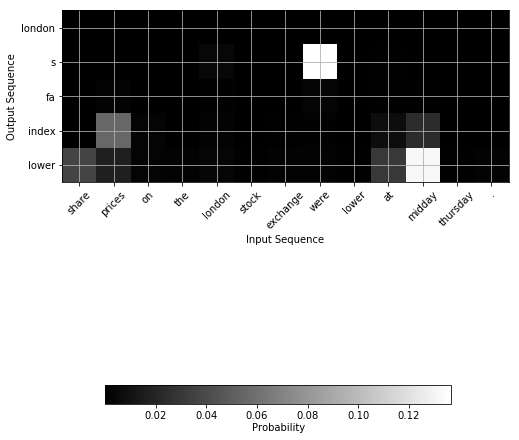

Test Article Sentense: share prices on the london stock exchange were higher in trading monday .
Predicted Summary: london share lunar index up most


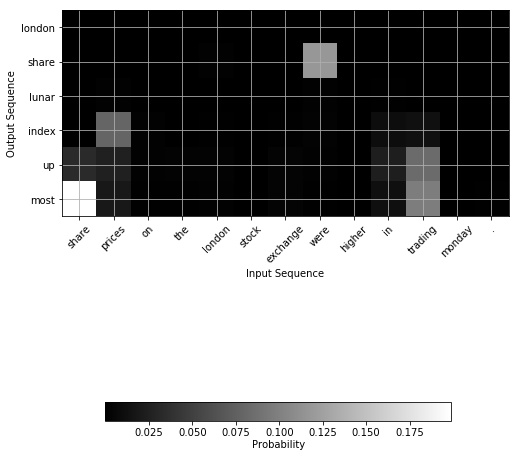

Test Article Sentense: share prices were lower at midday thursday on the london stock exchange .
Predicted Summary: london share prices lower


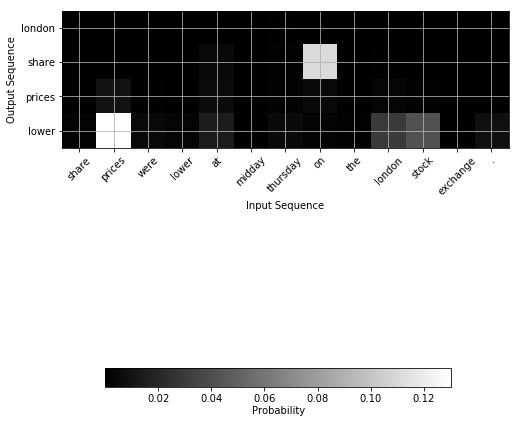

Test Article Sentense: former president spyros kyprianou died tuesday of cancer , doctors said .
Predicted Summary: former president president <unk> dies dies


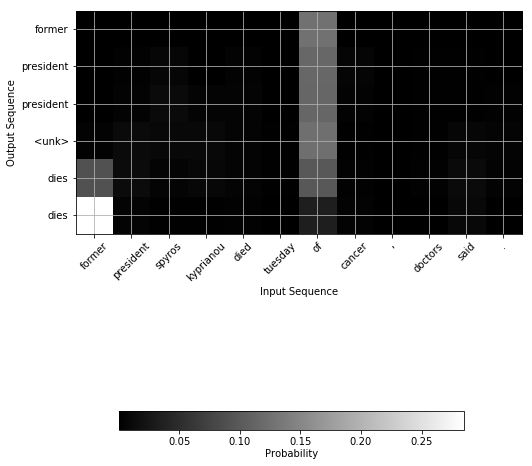

Test Article Sentense: tokyo stocks rose wednesday , boosted by overnight gains on wall street .
Predicted Summary: tokyo stocks rise higher higher


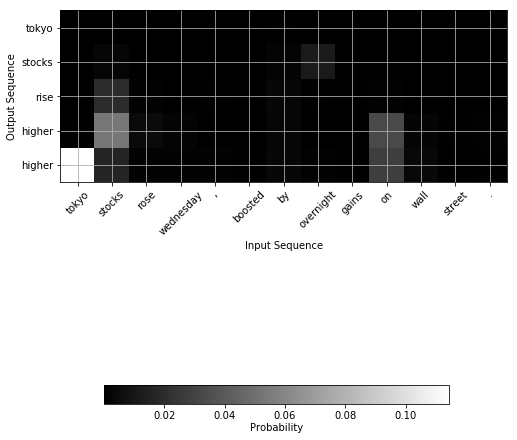

In [119]:
#viz.attention_map(text,test_data_vector,idx2word)
#Good 5 examples sentence index: 1, 202, 334, 435, 437
#Bad 5 examples sentence index: 89, 190, 225, 260, 308
#random 5 examples:a= 185, 444, 524, 830,917

for i in (1, 202, 334, 435, 437):
    plt.figure()

    viz.attention_map(test_article[i], X_test[i].reshape(1,24) ,idx2word_Y)
    
    print ('Test Article Sentense:',test_article[i])
    print ('Predicted Summary:',pred_list_att[i])

    plt.show()




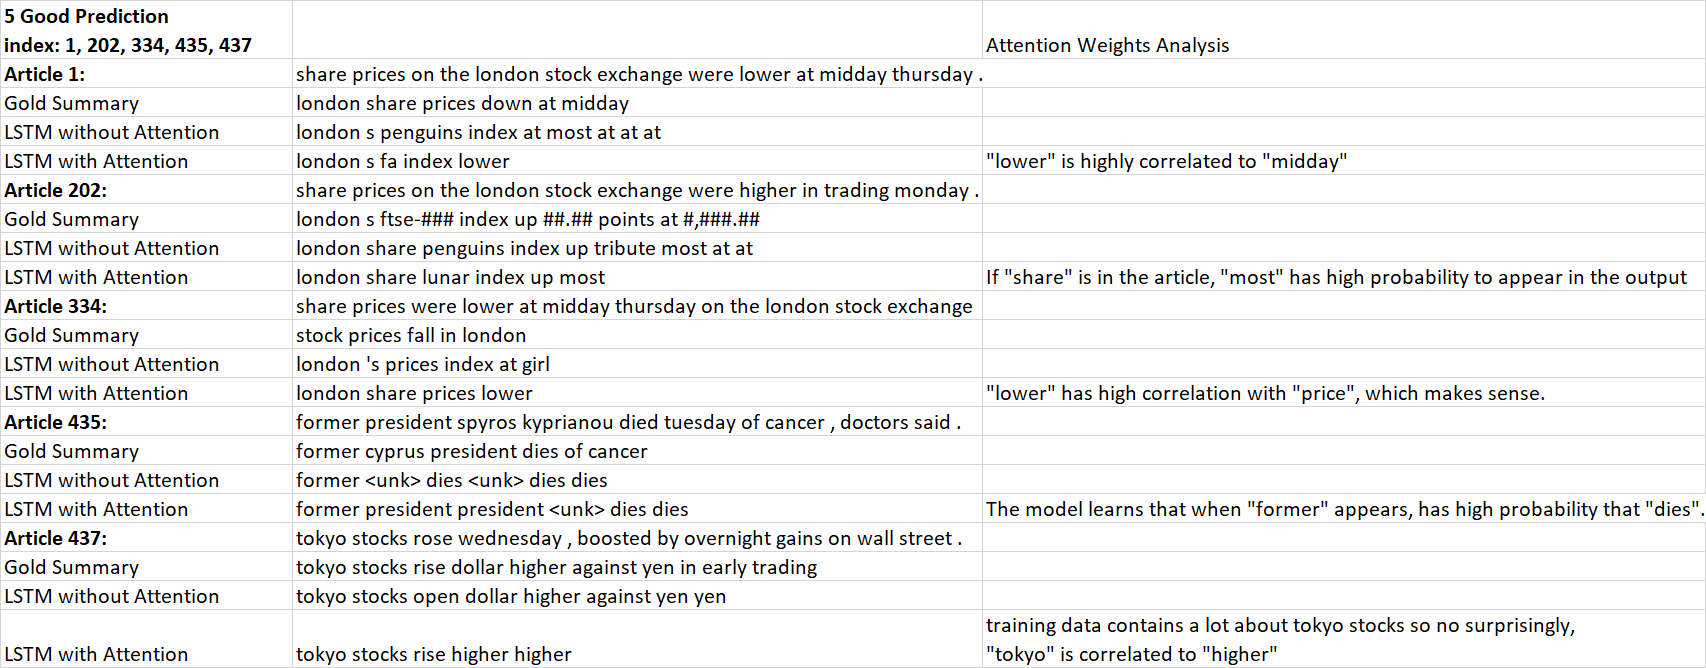

## 5 bad predictions

Test Article Sentense: oscar and grammy winner jamie foxx says music got him where he is today .
Predicted Summary: the sharper wounds wounds wounds wounds wounds wounds wounds wounds the the


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


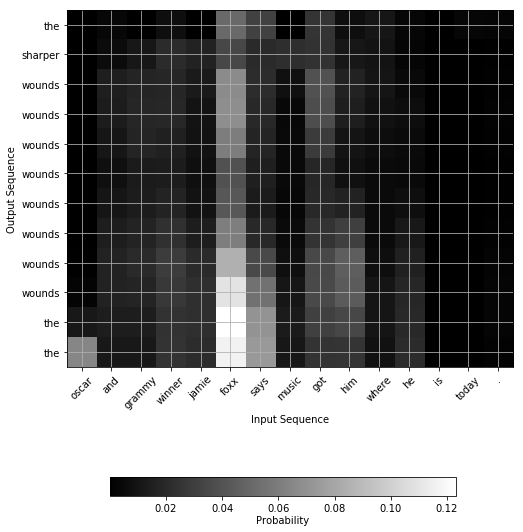

Test Article Sentense: england is n't exactly rushing to find sven-goran eriksson 's successor .
Predicted Summary: war 's to to to to <unk> <unk> in


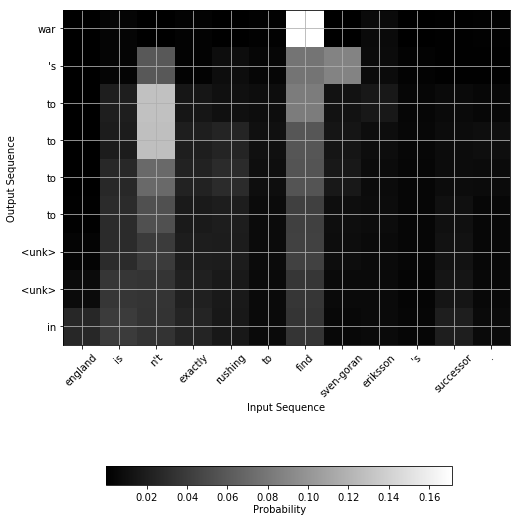

Test Article Sentense: organizers of the #### london olympics are moving into new headquarters .
Predicted Summary: <unk> 's to #### ####


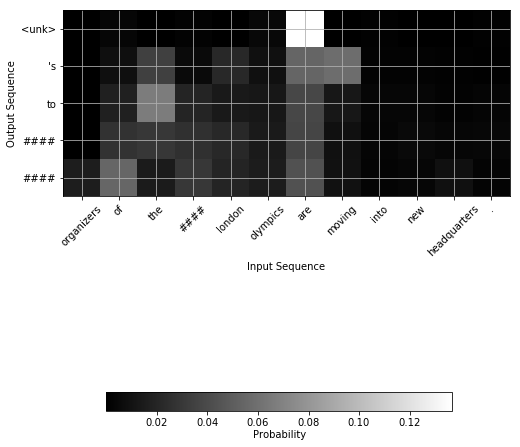

Test Article Sentense: police are searching for a robber disguised as president george w. bush .
Predicted Summary: <unk> <unk> to to to <unk>


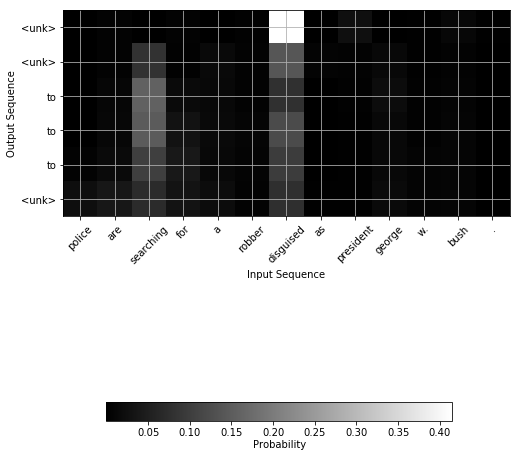

Test Article Sentense: no. ## michigan continued its mastery of the indiana hoosiers -- barely .
Predicted Summary: iran iran iran iran iran


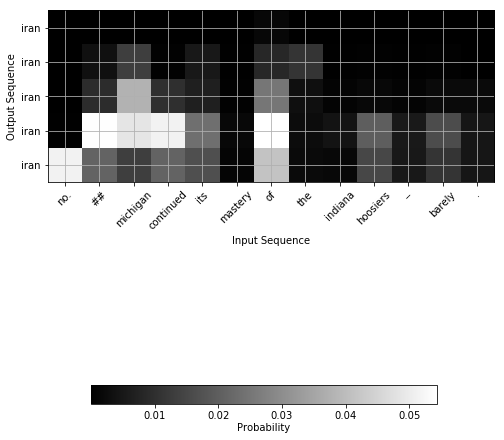

In [120]:
#Bad 5 examples sentence index: 89, 190, 225, 260, 308


for i in (89, 190, 225, 260, 308):
    plt.figure()

    viz.attention_map(test_article[i], X_test[i].reshape(1,24) ,idx2word_Y)
    
    print ('Test Article Sentense:',test_article[i])
    print ('Predicted Summary:',pred_list_att[i])

    plt.show()


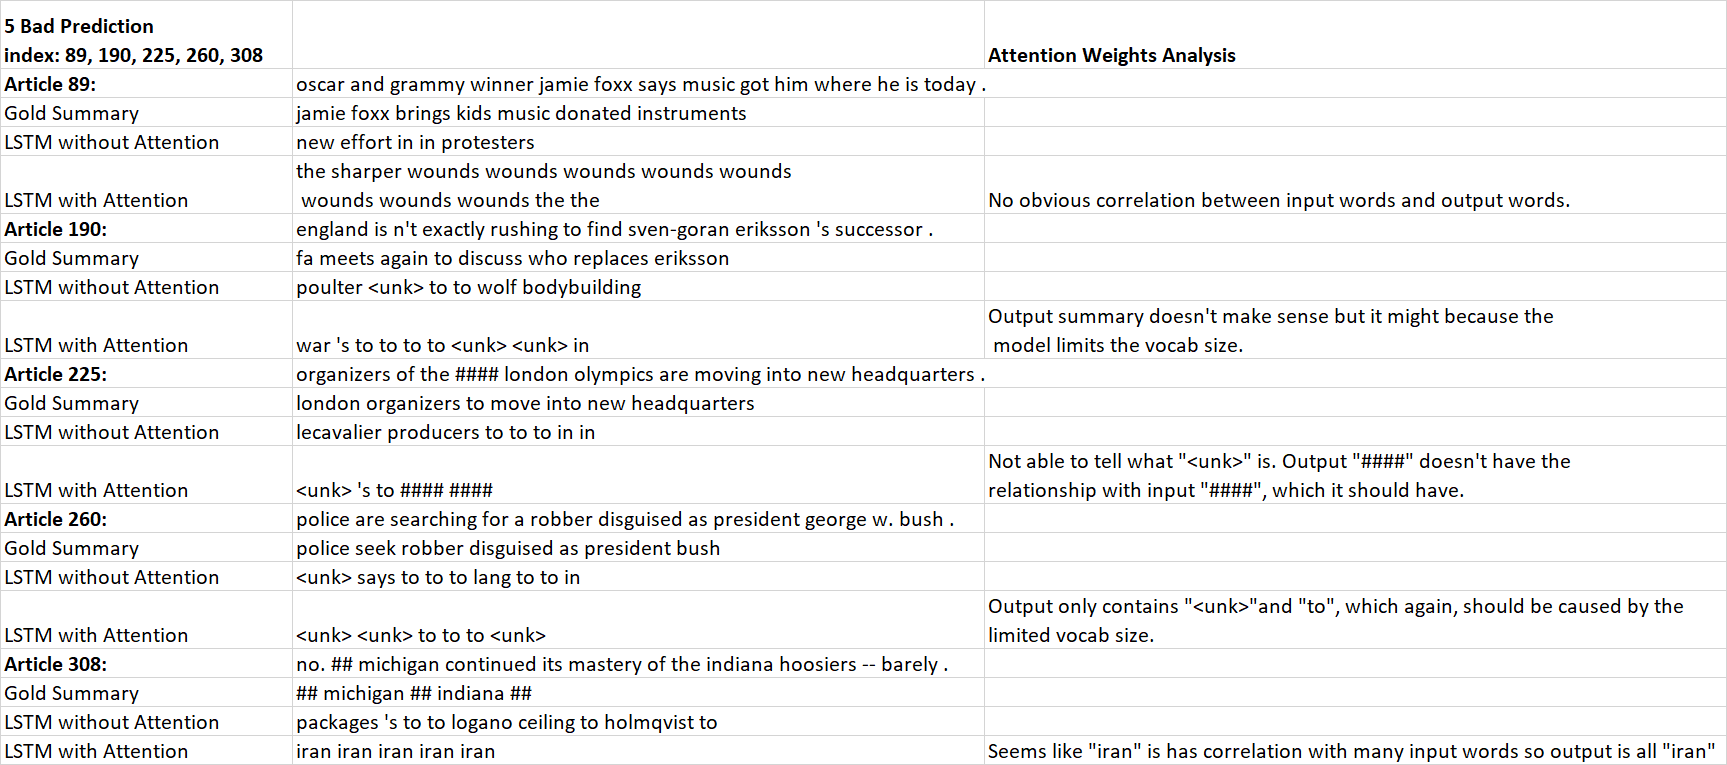

## 5 random predictions

In [116]:
import random
#random 5 examples
a=random.sample(range(1, 1000), 5)
a

[830, 185, 917, 524, 444]

Test Article Sentense: jim furyk has bounced back from his abysmal showing at the british open .
Predicted Summary: have # in #-#


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


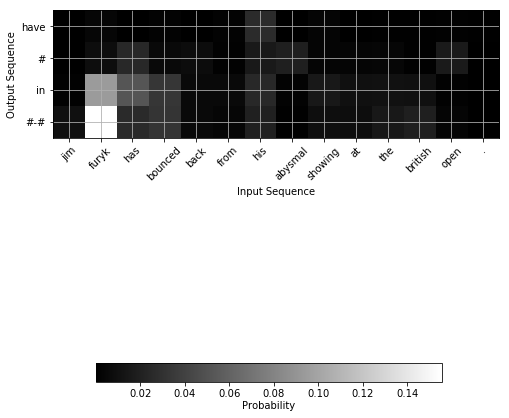

Test Article Sentense: parma signed reginaldo from fiorentina on a five-year contract thursday .
Predicted Summary: <unk> signs <unk> <unk> <unk>


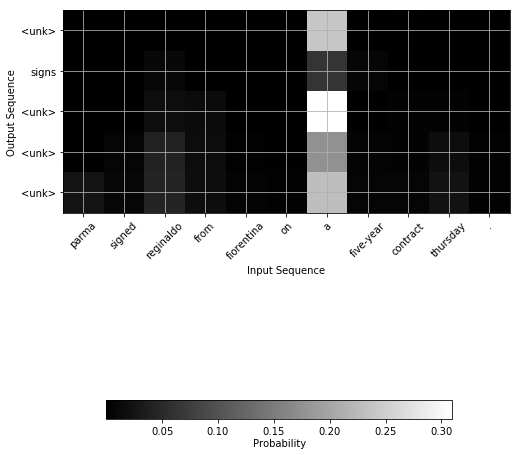

Test Article Sentense: prices on the hong kong stock exchange surged on bargain-hunting monday .
Predicted Summary: share kong share kong


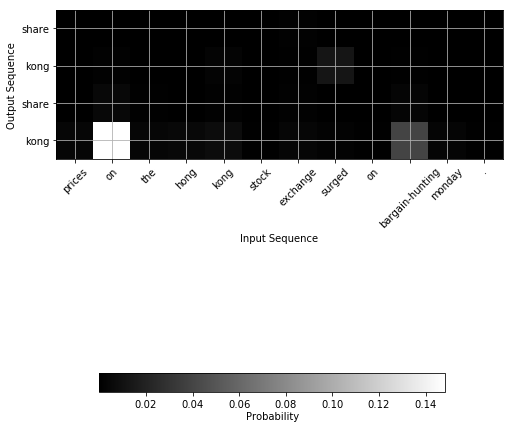

Test Article Sentense: americans are constantly told they are not saving enough for retirement .
Predicted Summary: job managers on for


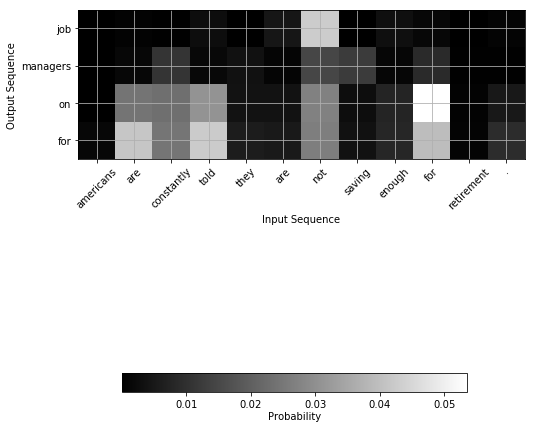

Test Article Sentense: `` liar , liar '' is just what the career doctor ordered for jim carrey .
Predicted Summary: <unk> <unk> <unk> <unk> <unk>


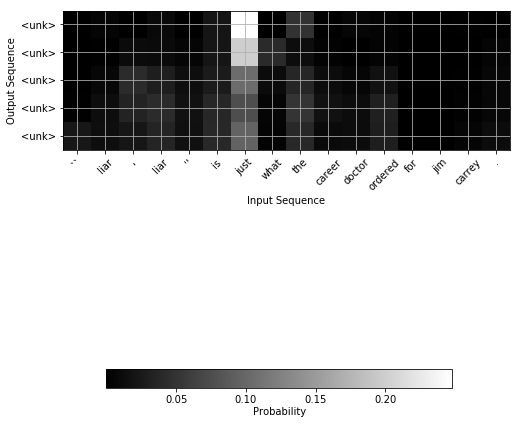

In [130]:
#random 5 examples:a= 185, 444, 524, 830,917

for i in (185, 444, 524, 830,917):
    plt.figure()

    viz.attention_map(test_article[i], X_test[i].reshape(1,24) ,idx2word_Y)
    
    print ('Test Article Sentense:',test_article[i])
    print ('Predicted Summary:',pred_list_att[i])

    plt.show()


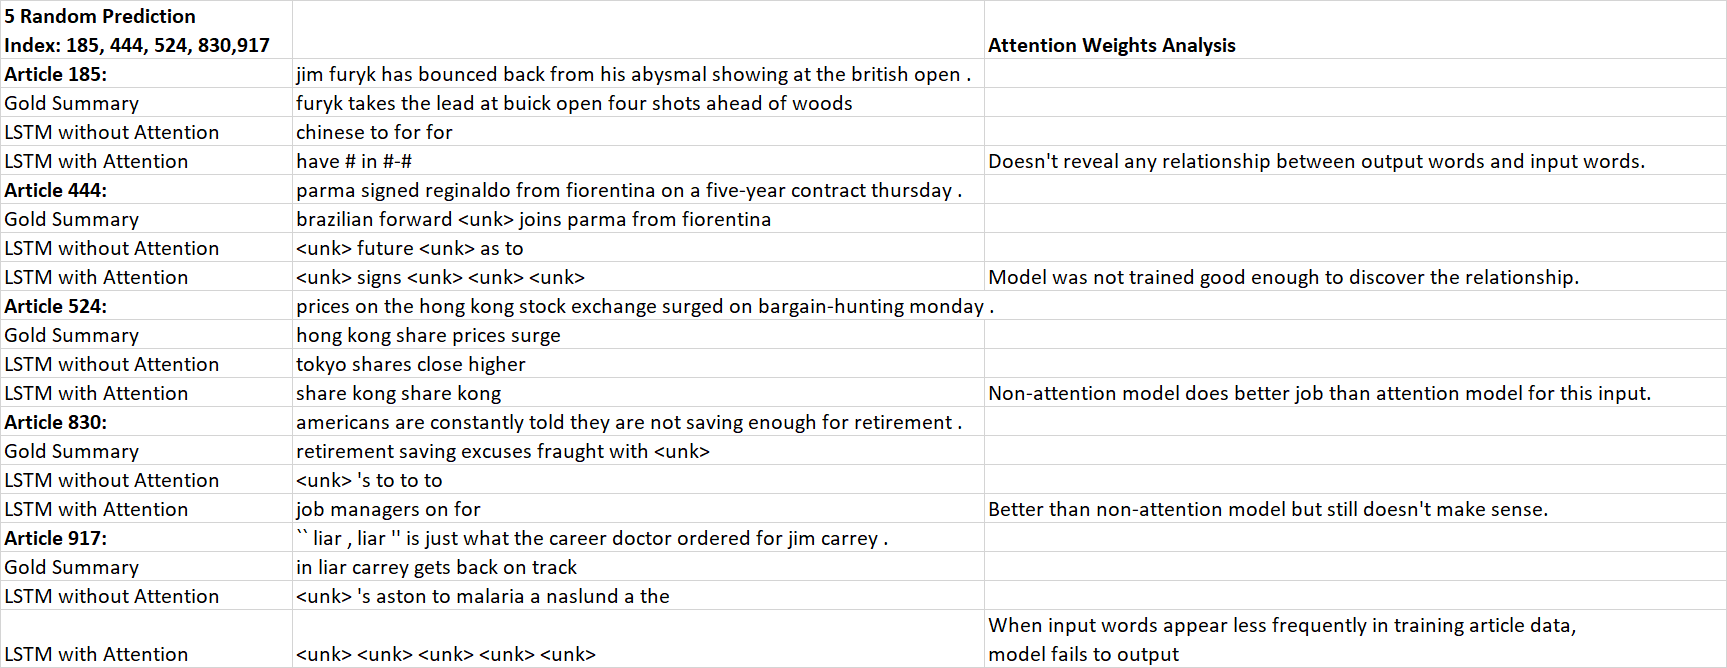